In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

from src.models import *
from src.data_generation import *

### Training on single environment

Parameters

In [9]:
# Trajectory parameters
n_traj = 100000                 # no. of trajectories per env
timesteps = 250                 # no. of timesteps
rayleigh_scale = 0.05
vonmises_kappa = 4 * np.pi

# Training parameters
bs = 32                         # batch size
epochs = 10                     # no. of epochs
lr = 1e-4                       # learning rate

# Model parameters
n_in = 2                        # Cartesian coordinates, no context
n_out = 250                     # no. of spatial representations
initial_state_size = 32         # size of initial state
scale = 0.2                     # scale of gaussian

Generate environment and some example trajectories

In [3]:
# Generate random env
env = PolygonEnvironment()

In [6]:
# Generate random trajectory
r, v = env.generate_random_trajectories(n_steps=timesteps, n_traj=200, rayleigh_scale=rayleigh_scale, vonmises_kappa=vonmises_kappa)

# Plot
fig, ax = env.plot_env()
ax.plot(*r.numpy()[:5].T)
plt.show()

Generate dataset

In [ ]:
# Generate random trajectories
r, v = env.generate_random_trajectories(n_steps=timesteps, n_traj=n_traj, rayleigh_scale=rayleigh_scale, vonmises_kappa=vonmises_kappa)

# Create dataset
dataset = TensorDataset(r, v)

or load one

In [15]:
# Load dataset and environment
ident = 'env_square_long'
ident = 'square-large'
folder = 'random_mixed'
folder = 'square-large'

env = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', folder, f'env_{ident}.pt'))
dataset = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', folder, f'dataset_{ident}.pt'))

In [16]:
len(dataset)

100000

Train model

In [17]:
device = 'cpu' # 'mps', 'cpu'

# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out, initial_state_size=initial_state_size, corr_across_space=False, scale=scale, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(epochs):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress):

        r_batch = r_batch.to(device)
        v_batch = v_batch.to(device)

        loss = model.train_step(x=v_batch, y=r_batch[:, 1:], optimizer=optimizer)
        # loss = model.train_step(x=(v_batch, r_batch[:, 0]), y=r_batch[:, 1:], optimizer=optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

loss: 0.009936: 100%|██████████| 3125/3125 [03:22<00:00, 15.45it/s]


In [18]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

Text(0, 0.5, 'Train Loss')

Generate test data

In [18]:
# Generate test data
r_test, v_test = env.generate_random_trajectories(n_traj=1, n_steps=1000000)
# Old
# r_test, v_test = generate_random_trajectories(env, n_traj=100, timesteps=timesteps, dt=0.1, speed_mean=0.5)

# Get spatial representation
p, _ = model.spatial_representation(v_test, model.initial_state(v_test.shape[0]))
p = p.detach().numpy()

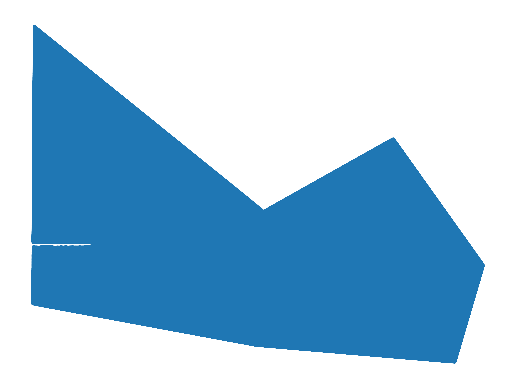

In [19]:
plt.plot(*r_test.detach().numpy()[:20].T)
plt.axis('off')
plt.show()

Check spatial representations

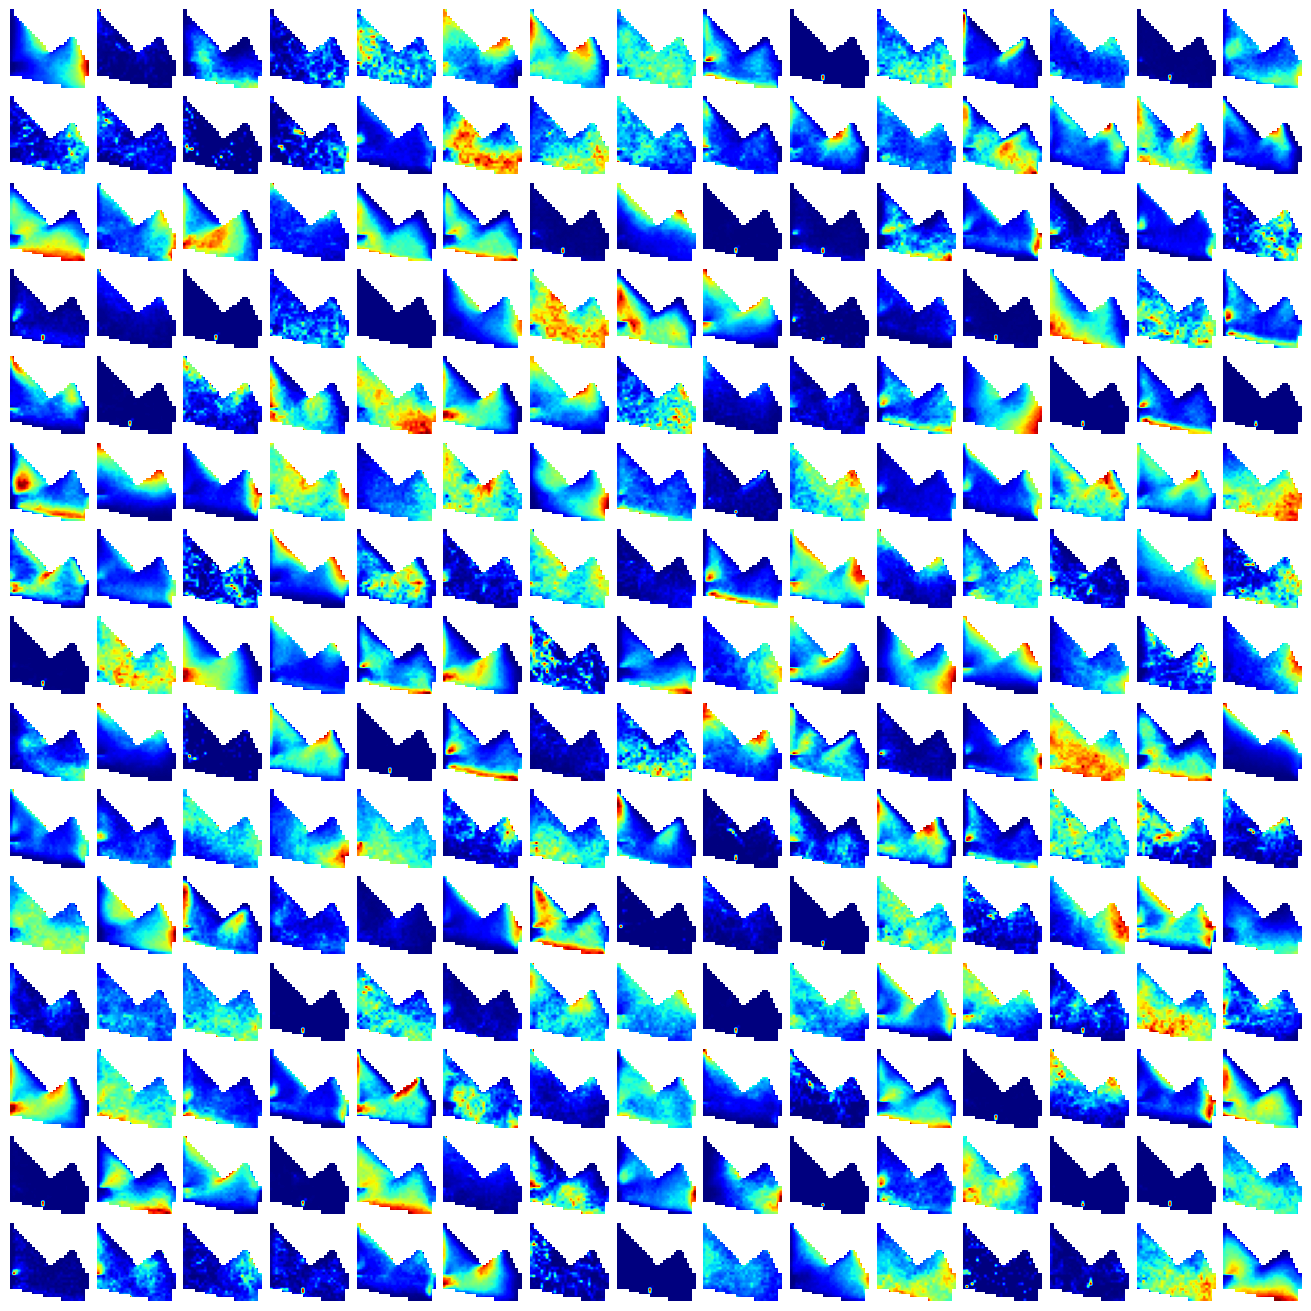

In [21]:
n_show = 15

fig, ax = plt.subplots(n_show, n_show, figsize=(13, 13), constrained_layout=True)

# Prepare stuff
r0 = r_test[:,1:].detach().numpy()
rs = r0.reshape(-1, 2)
ps = p.reshape(-1, n_out)

for i in range(n_show**2):
    hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
    ax[i//n_show, i%n_show].imshow(hist.T, origin="lower", cmap = "jet")
    ax[i//n_show, i%n_show].axis("off")

plt.show()

Check the distribution of peaks

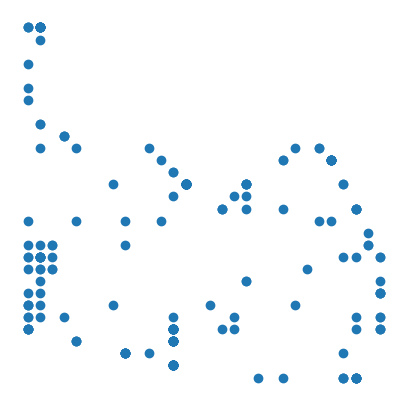

In [22]:
peaks = []
for i in range(ps.shape[-1]):
    hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
    peaks.append(np.unravel_index(np.nanargmax(hist), hist.shape))
peaks = np.array(peaks)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(peaks[:, 0], peaks[:, 1])
ax.axis('off')
plt.show()

Check the activity over time

In [23]:
fig, ax = plt.subplots()
ax.plot(np.mean(p, axis=0))
ax.set_xlabel("Time")
ax.set_ylabel("Activity")
ax.spines[['right', 'top']].set_visible(False)

### Train on multiple environments

In [24]:
# Load dataset and environment
ident = 'mixed'
folder = 'random_mixed'

envs = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', folder, f'env_{ident}.pt'))
dataset = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', folder, f'dataset_{ident}.pt'))

In [25]:
len(dataset)

200000

In [26]:
device = 'cpu' # 'mps', 'cpu'

# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out, initial_state_size=initial_state_size, corr_across_space=False, scale=scale, num_layers=1, init_weights='identity', device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(5):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress): # train loop

        r_batch = r_batch.to(device)
        v_batch = v_batch.to(device)

        loss = model.train_step(x=v_batch, y=r_batch[:, 1:], optimizer=optimizer)
        # loss = model.train_step(x=(v_batch, r_batch[:, 0]), y=r_batch[:, 1:], optimizer=optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

loss: 0.009919: 100%|██████████| 6250/6250 [05:04<00:00, 20.55it/s]


Text(0, 0.5, 'Train Loss')

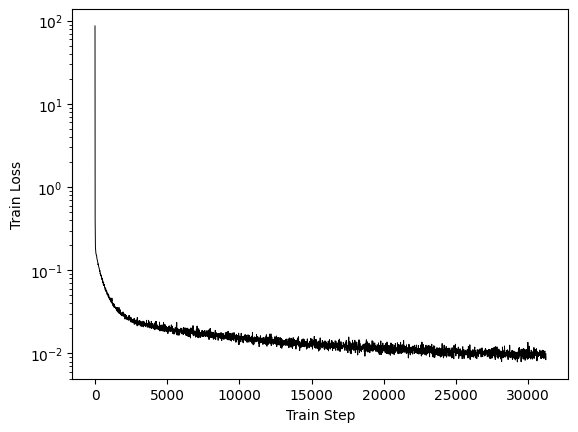

In [27]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

Check spatial representation for different environments

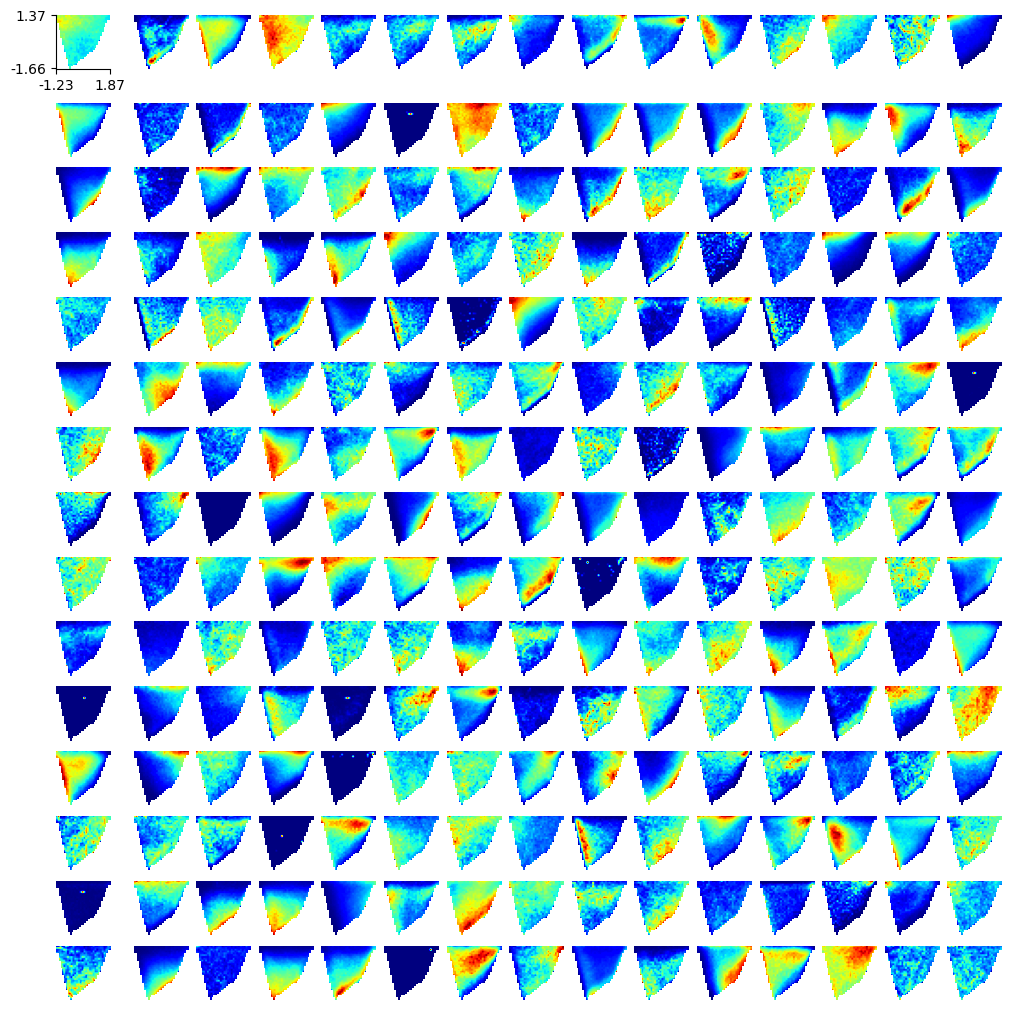

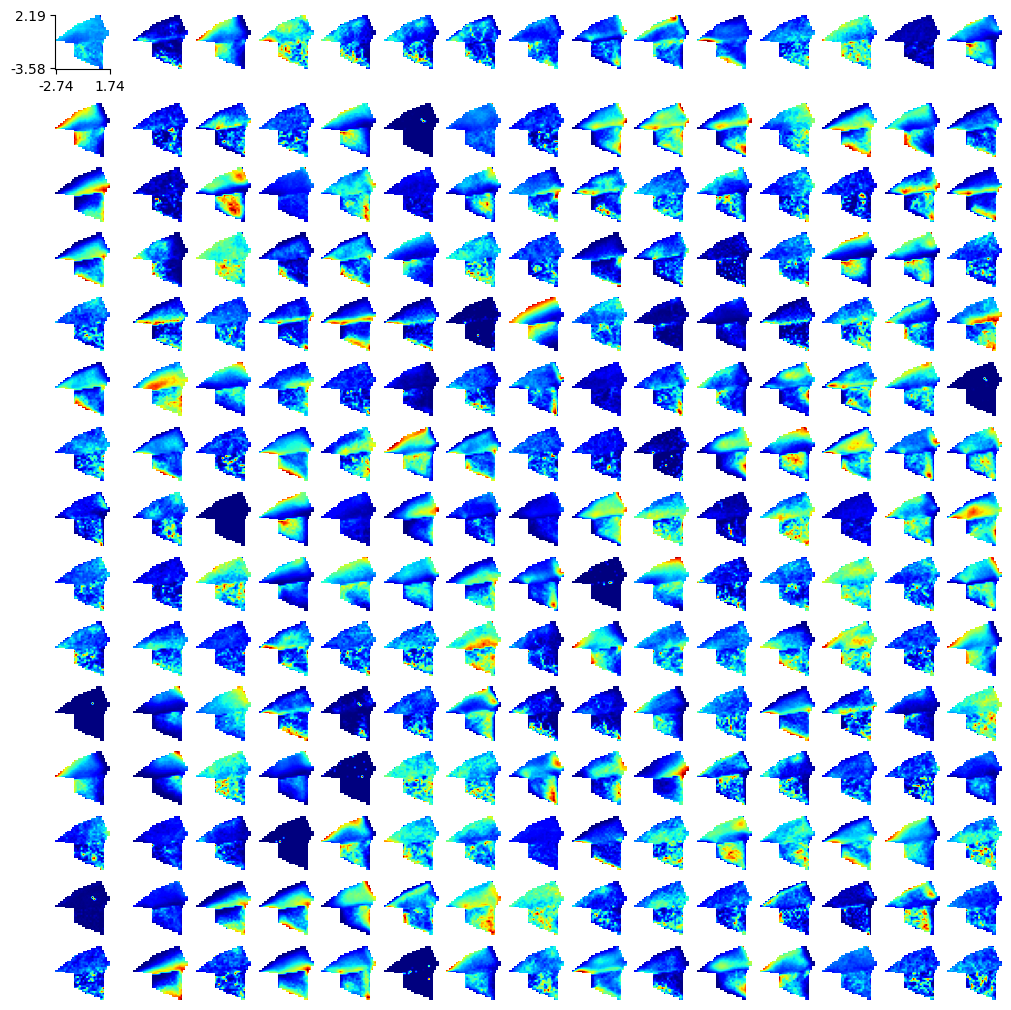

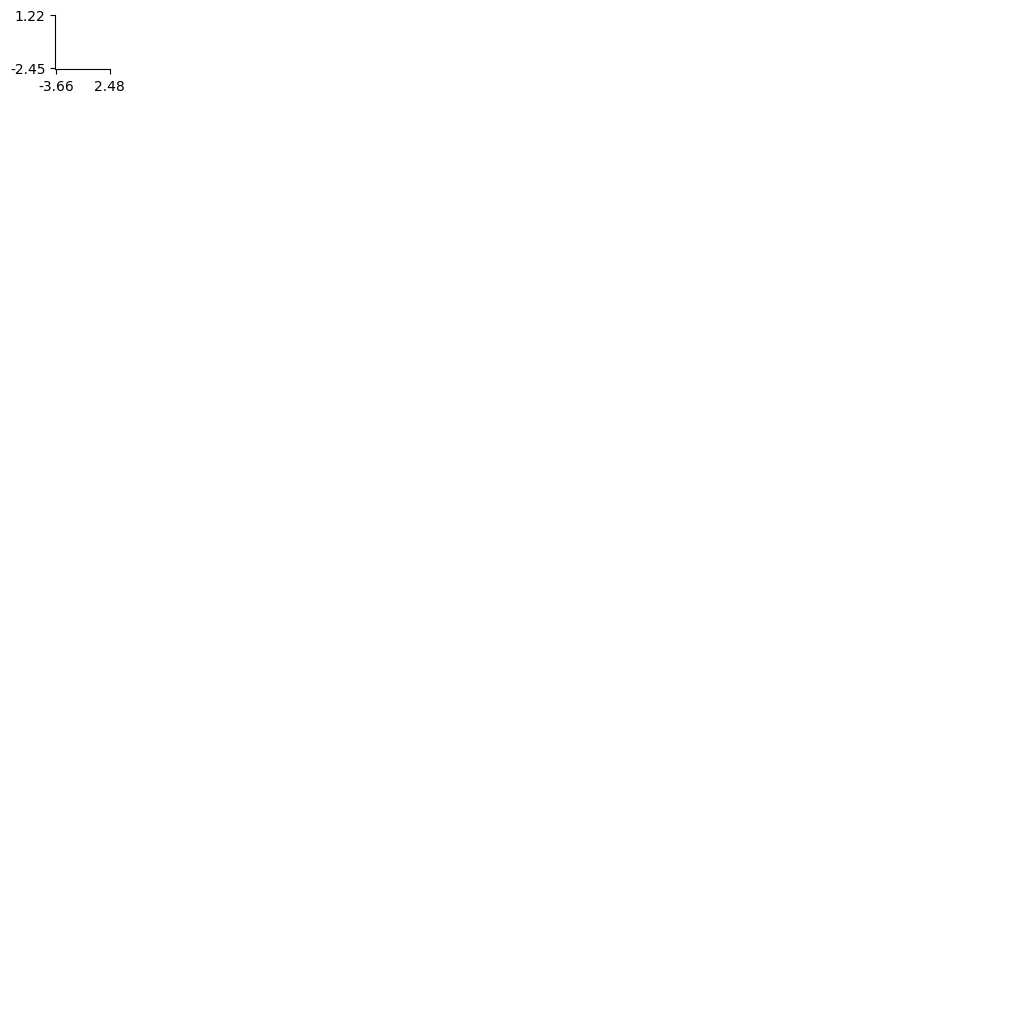

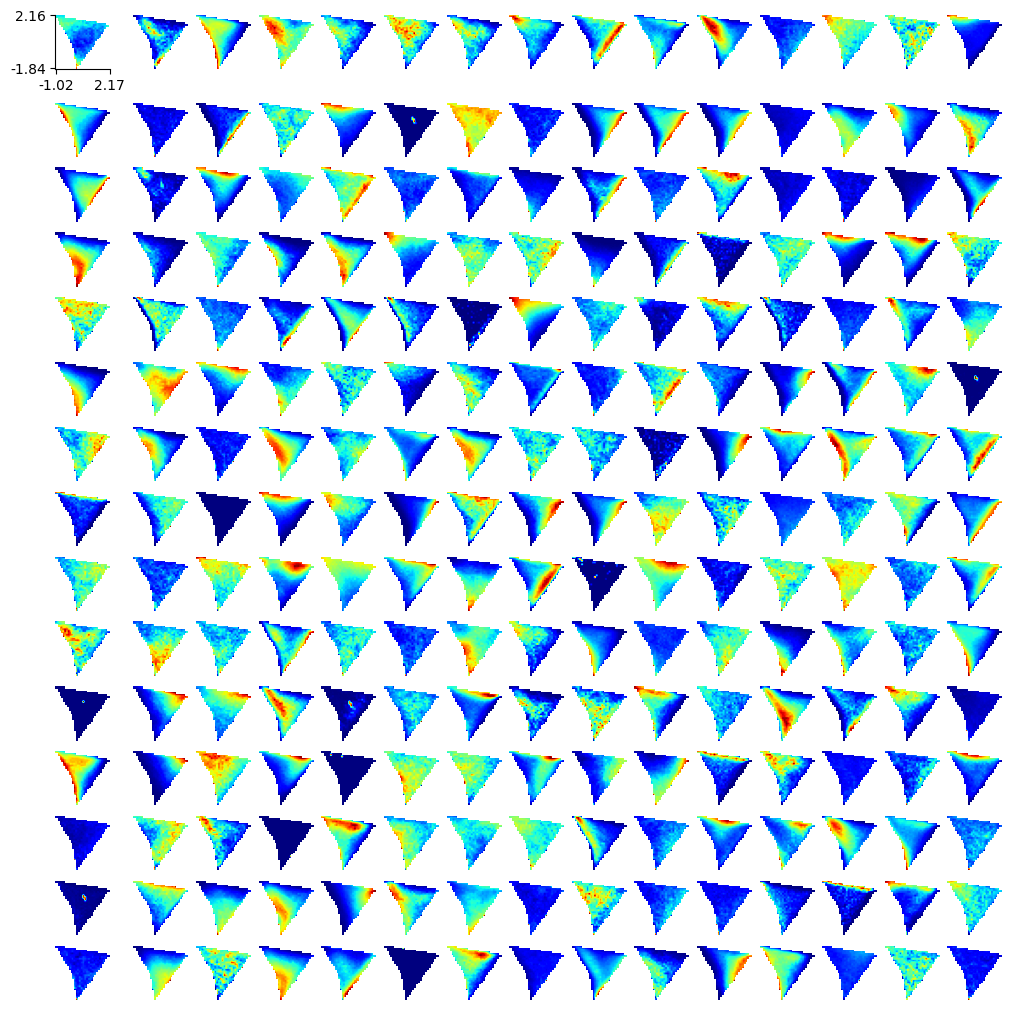

In [28]:
n_show = 15

for n in range(5):

    # Generate test trajectories
    r_test, v_test = envs[n].generate_random_trajectories(n_traj=1, n_steps=1000000)

    # Get spatial representation
    p, h = model.spatial_representation(v_test, model.initial_state(v_test.shape[0]))
    p = p.detach().numpy()

    fig, ax = plt.subplots(n_show, n_show, figsize=(10, 10), constrained_layout=True)

    # Prepare stuff
    r0 = r_test[:,1:].detach().numpy()
    ps = p.reshape(-1, n_out)
    rs = r0.reshape(-1, 2)

    for i in range(n_show**2):
        hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
        ax[i//n_show, i%n_show].imshow(hist.T, origin="lower", cmap="jet")
        if i != 0:
            ax[i//n_show, i%n_show].axis("off")
        else:
            ax[i//n_show, i%n_show].spines[['right', 'top']].set_visible(False)
            ax[i//n_show, i%n_show].set_xticks(np.linspace(0, 30, 2))
            ax[i//n_show, i%n_show].set_yticks(np.linspace(0, 30, 2))
            ax[i//n_show, i%n_show].set_xticklabels(np.linspace(envs[n].polygon.bounds[0], envs[n].polygon.bounds[2], 2).round(2))
            ax[i//n_show, i%n_show].set_yticklabels(np.linspace(envs[n].polygon.bounds[1], envs[n].polygon.bounds[3], 2).round(2))
    plt.show()